In [1]:
import pandas as pd
from seeq import spy

# Set the compatibility option so that you maximize the chance that SPy will remain compatible with your notebook/script
spy.options.compatibility = 193

In [2]:
# Log into Seeq Server if you're not using Seeq Data Lab:
spy.login(url='http://localhost:34216', credentials_file='../credentials.key', force=False)

# Workbook Templates

A _workbook_ is either a Workbench Analysis or an Organizer Topic. You create workbooks in SPy in a variety of ways:

- When you execute [spy.push()](spy.push.ipynb), a workbook will be created and the signals/conditions pushed will be scoped to that workbook.
- You can execute [spy.workbooks.push()](spy.workbooks.ipynb) to push workbooks that have been saved to disk.
- You can associate workbooks with asset trees that have been defined using [spy.assets](Asset%20Trees%202%20-%20Templates.ipynb).

The easiest way to define the configuration and content of a workbook is by using the Workbench and Organizer user interface to create _template workbooks_.

## Creating a Template

To create an Analysis template, you simply go into Workbench and create a workbook and as many worksheets as you need to define the template. Add "placeholder" items to the worksheet and arrange/configure the worksheet in whatever way makes sense for your use case. You can make entries in the worksheet's journal as well, including images and workstep links.

The `sinusoid()` function (using the Formula Tool) is a great way to create placeholders, because you can easily tailor it to the range and units you expect to see after you've substituted in real data in the steps that follow.

Once you're finished configuring the workbooks and worksheets, you will use SPy to save the workbook to disk so that you can later use it as a template. Just copy the URL from the browser's address bar and replace the value of the `url` variable in the code below:

```
url = 'http://localhost:34216/workbook/3EA21D97-782B-472B-B065-2DC76ECC152F/worksheet/4ED5F9B9-D82F-4017-ACEE-0EBBD1CC4E13'

workbooks = spy.workbooks.pull(url)
spy.workbooks.save(workbooks, 'My First Workbook Template')
```

This will save the workbook files to a folder on disk called `My First Workbook Template` and you'll see how we load it below.

### Installing Template Requirements

From SPy 193.0 on, SPy core does not install requirements needed for Templates by default. You may need to execute the install command below to use Templates in your python environment.

In [3]:
# pip install seeq-spy[templates]

## Loading a Template

Now let's say you want to use the template to control the workbook that is created when you call `spy.push()`.

In this example, we'll use a template that's built into this SPy documentation notebook. As you can see in the screenshot below, the workbook has been configured with several worksheets. The first is called "Trend Template" and has three items in it.

Notice how the Journal entry has text that is surrounded by double-curly-braces, like `{{favorite color}}`. This is referred to as a _mustache variable_ (named after the popular [Mustache templating system](https://en.wikipedia.org/wiki/Mustache_(template_system))). These variables can be replaced by values you specify in Python before you push, as you will see further below.

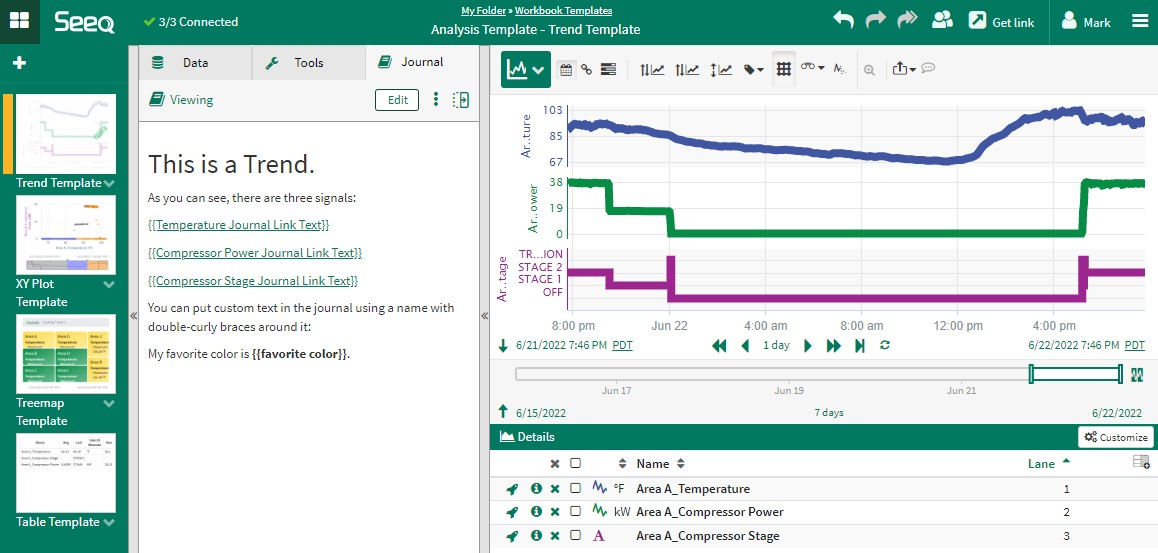

In [3]:
# Load the template shown above (included in SPy for the purposes of this example).
# Note how the `as_template_with_label` argument is used here, which is the key to establishing the loaded
# workbooks as templates instead of regular workbook objects. The specified label must be set to something
# unique across the entire Seeq service so that there aren't any identifier conflicts when pushing. If
# you're unsure, just include your name and that will usually be unique. For convenience in this example,
# we will use the logged-in user's name.
workbooks = spy.workbooks.load('./Support Files/Workbook Templates.zip',
                               as_template_with_label=f'{spy.user.username} Workbook Template Example 1')


# Grab the Analysis Workbook from the list
analysis_template = workbooks['Analysis Template']

# Retrieve a specific analysis worksheet from the list of returned workbooks
worksheet = analysis_template.worksheets['Trend Template']

worksheet

Worksheet "Trend Template" (C9BAE059-F996-46B8-AEC2-6FB62A45400A agent_api_key Workbook Template Example 1)

In [4]:
workbooks

[Workbook "Users >> mark.derbecker@seeq.com >> Workbook Templates >> Analysis Template" (F01FD57A-1112-4020-9430-CF27C2847D1B agent_api_key Workbook Template Example 1),
 Workbook "Users >> mark.derbecker@seeq.com >> Workbook Templates >> Asset Selector Analysis Template" (0EF59E6B-546A-6230-8251-02C2AE9EE8C1 agent_api_key Workbook Template Example 1),
 Workbook "Users >> mark.derbecker@seeq.com >> Workbook Templates >> Asset Selector Topic Template" (0EF59E6D-EE87-60A0-A4E3-AA13C6B2FE18 agent_api_key Workbook Template Example 1),
 Workbook "Users >> mark.derbecker@seeq.com >> Workbook Templates >> Data Lab Visualization Example" (6BAED6F7-3DF3-4238-AB18-7A9ABE284581 agent_api_key Workbook Template Example 1),
 Workbook "Users >> mark.derbecker@seeq.com >> Workbook Templates >> Topic Template" (90931EF8-D80B-4F22-8568-3683DD806D50 agent_api_key Workbook Template Example 1)]

When you load a workbook as a template, it exposes a `code` attribute that tells you how to plug specific items into the template. These are referred to as the _parameters_.

In [5]:
print(worksheet.code)

worksheet.parameters = {
    "9564A6B8-8A8F-4F6D-AC63-00EA38962B7A [Signal] Area A_Temperature": None,
    "D2C089B6-CE85-46FC-8392-E11CC0C08336 [Signal] Area A_Compressor Stage": None,
    "DCED9C36-A4BE-4783-9216-DC06B3F57D8C [Signal] Area A_Compressor Power": None,
    "Temperature Journal Link Text": None,
    "Compressor Power Journal Link Text": None,
    "Compressor Stage Journal Link Text": None,
    "favorite color": None
}


This worksheet contains three display items that can be replaced by items of our choosing, as well as several Mustache variables from the Journal.

You will see below how we replace the `None` values with the items we want.

## Pushing with a Template Worksheet

First let's create a metadata DataFrame with some sinusoids:

In [6]:
metadata_df = pd.DataFrame([{
    'Name': 'Sinusoid 1',
    'Type': 'Signal',
    'Formula': 'sinusoid(1h)'
}, {
    'Name': 'Sinusoid 2',
    'Type': 'Signal',
    'Formula': 'sinusoid(2h)'
}, {
    'Name': 'Sinusoid 3',
    'Type': 'Signal',
    'Formula': 'sinusoid(3h)'
}])

Next, we will copy and paste the code block that we printed earlier into a real code cell so that we can set the parameters appropriately. In this example, we're just specifying the `Name` of the signals (replacing the `None` placeholders), but we could have supplied `ID`, `Type`, `Path` and/or `Asset` values that correspond to the row being pushed. (It can also be a one-row DataFrame instead of a dictionary.)

In [7]:
worksheet.parameters = {
    "9564A6B8-8A8F-4F6D-AC63-00EA38962B7A [Signal] Area A_Temperature": {'Name': 'Sinusoid 1'},
    "DCED9C36-A4BE-4783-9216-DC06B3F57D8C [Signal] Area A_Compressor Power": {'Name': 'Sinusoid 2'},
    "D2C089B6-CE85-46FC-8392-E11CC0C08336 [Signal] Area A_Compressor Stage": {'Name': 'Sinusoid 3'},
    "Temperature Journal Link Text": 'SINUSOID 1',
    "Compressor Power Journal Link Text": 'SINUSOID 2',
    "Compressor Stage Journal Link Text": 'SINUSOID 3',
    "favorite color": 'blue'
}

# Give the worksheet a different name than "Trend Template"
worksheet.name = 'My Trend!'

Now we push the metadata DataFrame and pass in the worksheet argument:

In [8]:
spy.push(metadata=metadata_df, workbook='Workbook Template Example 1', worksheet=worksheet)

,Name,Type,Formula,Scoped To,Datasource Class,Datasource ID,Formula Parameters,Data ID,ID,Push Result
0,Sinusoid 1,CalculatedSignal,sinusoid(1h),0EF5A987-CA96-75E0-A06A-903E9F4EB5C9,Seeq Data Lab,Seeq Data Lab,[],[0EF5A987-CA96-75E0-A06A-903E9F4EB5C9] {Signal...,0EF5A987-CB88-7110-B9D7-E3F3BA958562,Success
1,Sinusoid 2,CalculatedSignal,sinusoid(2h),0EF5A987-CA96-75E0-A06A-903E9F4EB5C9,Seeq Data Lab,Seeq Data Lab,[],[0EF5A987-CA96-75E0-A06A-903E9F4EB5C9] {Signal...,0EF5A987-CBB4-6030-9B9C-F9475973ADD2,Success
2,Sinusoid 3,CalculatedSignal,sinusoid(3h),0EF5A987-CA96-75E0-A06A-903E9F4EB5C9,Seeq Data Lab,Seeq Data Lab,[],[0EF5A987-CA96-75E0-A06A-903E9F4EB5C9] {Signal...,0EF5A987-CBCC-66D0-B8AC-1C8604FA0540,Success


When you click on the link to the workbook/worksheet above, you should see the following:

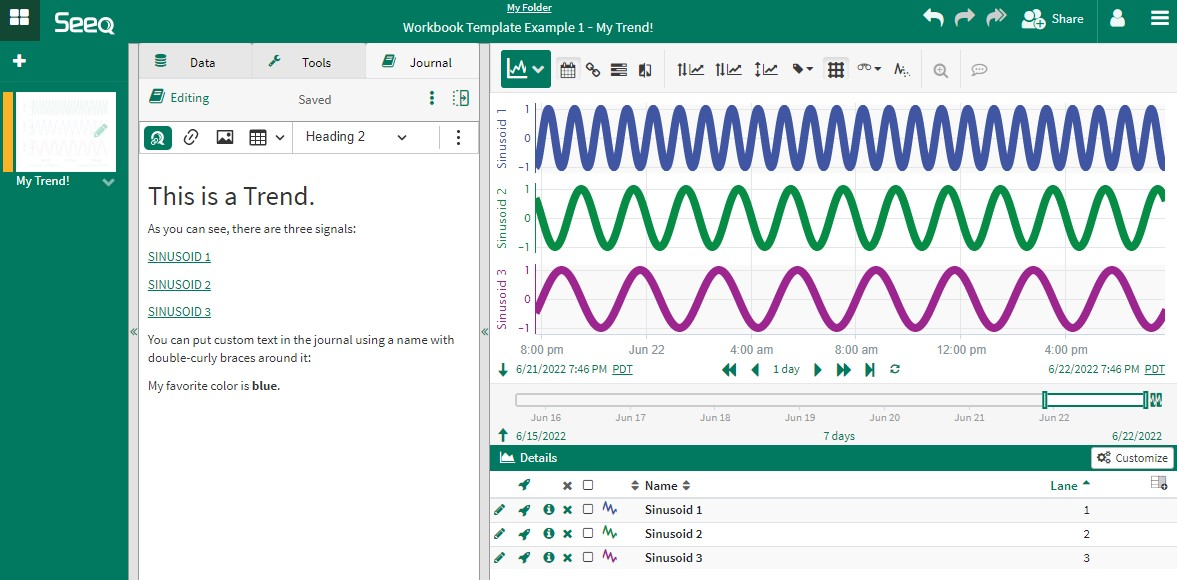

Notice that all of the items have been replaced with the things we pushed, and the mustache variables in the Journal have been replaced by the values we specified in the `worksheet.parameters` above.

Note: Both Journals and Organizer Topics are backed by HTML markup. If you want to supply HTML as a parameter for one of the mustache variables, you must declare the variable as `{{&Variable Name}}`. That way the HTML will not be "escaped" and be shown to the user literally.

## Pushing with a Template Workbook

You can also push an entire workbook instead of just a single worksheet. Following much the same pattern, you will print the parameters code for the workbook like so:

In [9]:
workbooks = spy.workbooks.load('./Support Files/Workbook Templates.zip',
                               as_template_with_label=f'{spy.user.username} Workbook Template Example 2')

In [10]:
# Retrieve a specific workbook from the list of returned workbooks
workbook = workbooks['Analysis Template']

print(workbook.code)

workbook.parameters = {
    "9564A6B8-8A8F-4F6D-AC63-00EA38962B7A [Signal] Area A_Temperature": None,
    "D2C089B6-CE85-46FC-8392-E11CC0C08336 [Signal] Area A_Compressor Stage": None,
    "DCED9C36-A4BE-4783-9216-DC06B3F57D8C [Signal] Area A_Compressor Power": None,
    "Temperature Journal Link Text": None,
    "Compressor Power Journal Link Text": None,
    "Compressor Stage Journal Link Text": None,
    "favorite color": None,
    "07F3161F-6644-4505-BC33-16D6155B004E [Condition] Hot": None,
    "D16FC368-AE8E-47B4-B1A3-9C2A3FBA2BB6 [Asset] Example >> Cooling Tower 1": None,
    "4B40EAFC-91ED-4AB0-8199-F21AF40A8350 [Asset] Example >> Cooling Tower 1 >> Area A": None,
    "8A4F0E26-8A0C-4127-9E11-B67E031C6049 [Signal] Example >> Cooling Tower 1 >> Area A >> Temperature": None
}


Again, we will create a DataFrame full of signals, but this time we'll put them in an asset tree so we can illustrate how to properly populate a Treemap template.

In [11]:
metadata_df = pd.DataFrame([
    {'Path': 'Waveforms', 'Asset': 'Waveforms 1', 'Name': 'Sinusoid', 'Type': 'Signal', 'Formula': 'sinusoid(1h)'},
    {'Path': 'Waveforms', 'Asset': 'Waveforms 1', 'Name': 'Sawtooth', 'Type': 'Signal', 'Formula': 'sawtooth(1h)'},
    {'Path': 'Waveforms', 'Asset': 'Waveforms 1', 'Name': 'Square', 'Type': 'Signal', 'Formula': 'squareWave(1h)'},
    {'Path': 'Waveforms', 'Asset': 'Waveforms 1', 'Name': 'Hours', 'Type': 'Condition', 'Formula': 'hours()'},
    {'Path': 'Waveforms', 'Asset': 'Waveforms 2', 'Name': 'Sinusoid', 'Type': 'Signal',
     'Formula': 'sinusoid(12h, 15V)'},
    {'Path': 'Waveforms', 'Asset': 'Waveforms 2', 'Name': 'Sawtooth', 'Type': 'Signal',
     'Formula': 'sawtooth(12h, 15V)'},
    {'Path': 'Waveforms', 'Asset': 'Waveforms 2', 'Name': 'Square', 'Type': 'Signal',
     'Formula': 'squareWave(12h, 15V)'},
    {'Path': 'Waveforms', 'Asset': 'Waveforms 2', 'Name': 'Hours', 'Type': 'Condition', 'Formula': 'hours()'},
])

In [12]:
# Provide a name for the pushed workbook. Unlike the previous example where the workbook name was specified
# as part of the push arguments, in this case we override it on the template object. You can override any
# property of a workbook/worksheet prior to pushing.
workbook.name = 'Workbook Template Example 2'

workbook.parameters = {
    "DCED9C36-A4BE-4783-9216-DC06B3F57D8C [Signal] Area A_Compressor Power": {'Asset': 'Waveforms 1',
                                                                              'Name': 'Sinusoid'},
    "9564A6B8-8A8F-4F6D-AC63-00EA38962B7A [Signal] Area A_Temperature": {'Asset': 'Waveforms 1', 'Name': 'Sawtooth'},
    "D2C089B6-CE85-46FC-8392-E11CC0C08336 [Signal] Area A_Compressor Stage": {'Asset': 'Waveforms 1', 'Name': 'Square'},
    "Temperature Journal Link Text": 'Sawtooth',
    "Compressor Power Journal Link Text": 'Sinusoid',
    "Compressor Stage Journal Link Text": 'Square',
    "favorite color": 'beige',

    # This is the condition used to color the treemap
    "07F3161F-6644-4505-BC33-16D6155B004E [Condition] Hot": {'Asset': 'Waveforms 1', 'Name': 'Hours'},

    # This is the signal used for the Maximum statistic in the treemap and its parent assent
    "8A4F0E26-8A0C-4127-9E11-B67E031C6049 [Signal] Example >> Cooling Tower 1 >> Area A >> Temperature":
        {'Asset': 'Waveforms 1', 'Name': 'Sawtooth'},
    "4B40EAFC-91ED-4AB0-8199-F21AF40A8350 [Asset] Example >> Area A": {'Asset': 'Waveforms 1', 'Type': 'Asset'},

    # This is the parent asset that will be used in the Treemap worksheet
    "D16FC368-AE8E-47B4-B1A3-9C2A3FBA2BB6 [Asset] Cooling Tower 1": {'Asset': 'Waveforms', 'Type': 'Asset'}
}

Now when we push, we'll pass the `workbook` argument instead of the `worksheet` argument.

In [13]:
pushed_df = spy.push(metadata=metadata_df, workbook=workbook)

After pushing, the link will take you to a workbook that has four worksheets whose contents correspond to the template parameters specified above:

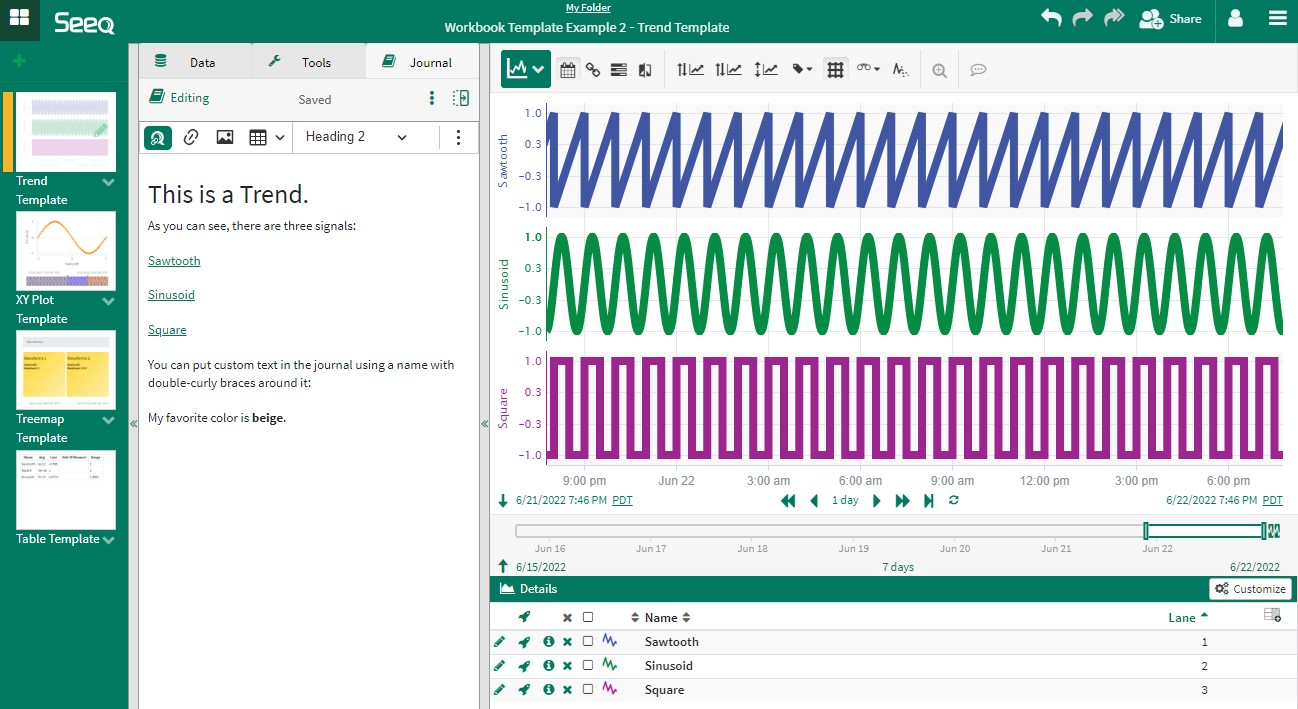

### Using Pre-existing Signals/Conditions/Scalars etc

In the examples above, we are both creating items (signals/conditions/scalars/etc) and using them in a template -- all in one call to `spy.push()`.

If the items are already created, then you can use `spy.workbooks.push()` instead, like so:

In [14]:
# Retrieve Area B items from the Example Data asset tree
area_b_signals = spy.search({'Path': 'Example >> Cooling Tower 1', 'Asset': 'Area B'})

workbooks = spy.workbooks.load('./Support Files/Workbook Templates.zip',
                               as_template_with_label=f'{spy.user.username} Workbook Template Example 2.1')

workbook = workbooks['Analysis Template']

workbook.name = 'Workbook Template Example 2.1'

workbook.parameters = {
    "DCED9C36-A4BE-4783-9216-DC06B3F57D8C [Signal] Area A_Compressor Power":
        # You can specify a (single) DataFrame row as long as it contains a valid ID column
        area_b_signals[area_b_signals['Name'] == 'Compressor Power'],
    "9564A6B8-8A8F-4F6D-AC63-00EA38962B7A [Signal] Area A_Temperature":
        area_b_signals[area_b_signals['Name'] == 'Temperature'],
    "D2C089B6-CE85-46FC-8392-E11CC0C08336 [Signal] Area A_Compressor Stage":
        # You can specify an ID directly as a string
        area_b_signals[area_b_signals['Name'] == 'Compressor Stage'].iloc[0]['ID']
}

spy.workbooks.push(workbook)

,ID,Name,Type,Workbook Type,Count,Time,Errors,Result,Pushed Workbook ID,URL
0,F01FD57A-1112-4020-9430-CF27C2847D1B agent_api_key Workbook Template Example 2.1,Workbook Template Example 2.1,Workbook,Analysis,13,00:00:00.63,0,Success,0EF5A987-E447-E840-BF03-A3E65C9ED79D,link


,ID,Name,Type,Workbook Type,Count,Time,Errors,Result,Pushed Workbook ID,URL
0,F01FD57A-1112-4020-9430-CF27C2847D1B agent_api...,Workbook Template Example 2.1,Workbook,Analysis,13,0:00:00.630423,0,Success,0EF5A987-E447-E840-BF03-A3E65C9ED79D,http://localhost:34216/workbook/0EF5A987-E447-...


When you click the link to examine the pushed workbook, you'll see that the `Area A_Xxxxx` signals have been replaced with equivalent `Example >> Cooling Tower 1 >> Area B` signals.

## Modifying the Display Items

In some cases, you need to have more dynamic control over what items are displayed in your worksheet and how. An efficient course of action is to create a worksheet/workbook template that is set up the way you want it with a handful of placeholder items. Then you can completely replace those items with a different set that may be larger or smaller than what's in the template.

You can change the elements of a worksheet by making function calls and manipulating attributes of the worksheet object. Documentation on the various attributes of a worksheet is available in the [spy.workbooks.AnalysisWorksheet](https://python-docs.seeq.com/reference/submodules/workbooks.html#seeq.spy.workbooks.AnalysisWorksheet) online documentation.

Here's an example:

In [15]:
template_label = 'Workbook Template Example 2.2'
workbooks = spy.workbooks.load('./Support Files/Workbook Templates.zip',
                               as_template_with_label=f'{spy.user.username} {template_label}')

workbook = workbooks['Analysis Template']
workbook.name = template_label

worksheet = workbook.worksheets['Trend Template']
worksheet.name = 'Cooling Tower 1'

# Grab all Temperature signals under Cooling Tower 1
areas_to_add = spy.search({'Path': 'Example >> Cooling Tower 1', 'Name': 'Temperature'})

# Copy this into a variable where each row is indexed by Path/Asset/Name for easy manipulation
display_items = areas_to_add.set_index(['Path', 'Asset', 'Name'])

# See "Manipulating Worksheets" section of spy.workbooks.ipynb for more info on these display item attributes
display_items.at[('Example >> Cooling Tower 1', 'Area A', 'Temperature'), 'Color'] = '#FF0000'
display_items.at[('Example >> Cooling Tower 1', 'Area B', 'Temperature'), 'Lane'] = 2
display_items.at[('Example >> Cooling Tower 1', 'Area B', 'Temperature'), 'Axis Group'] = 'B'
display_items.at[('Example >> Cooling Tower 1', 'Area C', 'Temperature'), 'Lane'] = 2
display_items.at[('Example >> Cooling Tower 1', 'Area C', 'Temperature'), 'Axis Group'] = 'B'
display_items.at[('Example >> Cooling Tower 1', 'Area J', 'Temperature'), 'Line Style'] = 'Short Dash-Dot'
display_items.at[('Example >> Cooling Tower 1', 'Area J', 'Temperature'), 'Line Width'] = 5

# Sort by the index so that they appear in order (Area A, then Area B etc)
display_items.sort_index(inplace=True)

# Reset the index since the worksheet expects a Name column
display_items.reset_index(inplace=True)

# Assign the manipulated DataFrame to the worksheet
worksheet.display_items = display_items

# Create another worksheet with Cooling Tower 2 items. We must supply a unique label to the copy() function for
# bookkeeping purposes.
worksheet2 = worksheet.copy(f'{spy.user.username} {template_label} - Cooling Tower 2')
worksheet2.name = 'Cooling Tower 2'

areas_to_add = spy.search({'Path': 'Example >> Cooling Tower 2', 'Name': 'Temperature'})
worksheet2.display_items = areas_to_add

# Remove other worksheets
workbook.worksheets = [w for w in workbook.worksheets if 'Cooling Tower' in w.name]

spy.workbooks.push(workbook)

,ID,Name,Type,Workbook Type,Count,Time,Errors,Result,Pushed Workbook ID,URL
0,F01FD57A-1112-4020-9430-CF27C2847D1B agent_api_key Workbook Template Example 2.2,Workbook Template Example 2.2,Workbook,Analysis,8,00:00:00.32,0,Success,0EF5A987-F546-71A0-8B3E-82DB3BBF0022,link


,ID,Name,Type,Workbook Type,Count,Time,Errors,Result,Pushed Workbook ID,URL
0,F01FD57A-1112-4020-9430-CF27C2847D1B agent_api...,Workbook Template Example 2.2,Workbook,Analysis,8,0:00:00.319439,0,Success,0EF5A987-F546-71A0-8B3E-82DB3BBF0022,http://localhost:34216/workbook/0EF5A987-F546-...


The resulting worksheet/workbook should look like this:

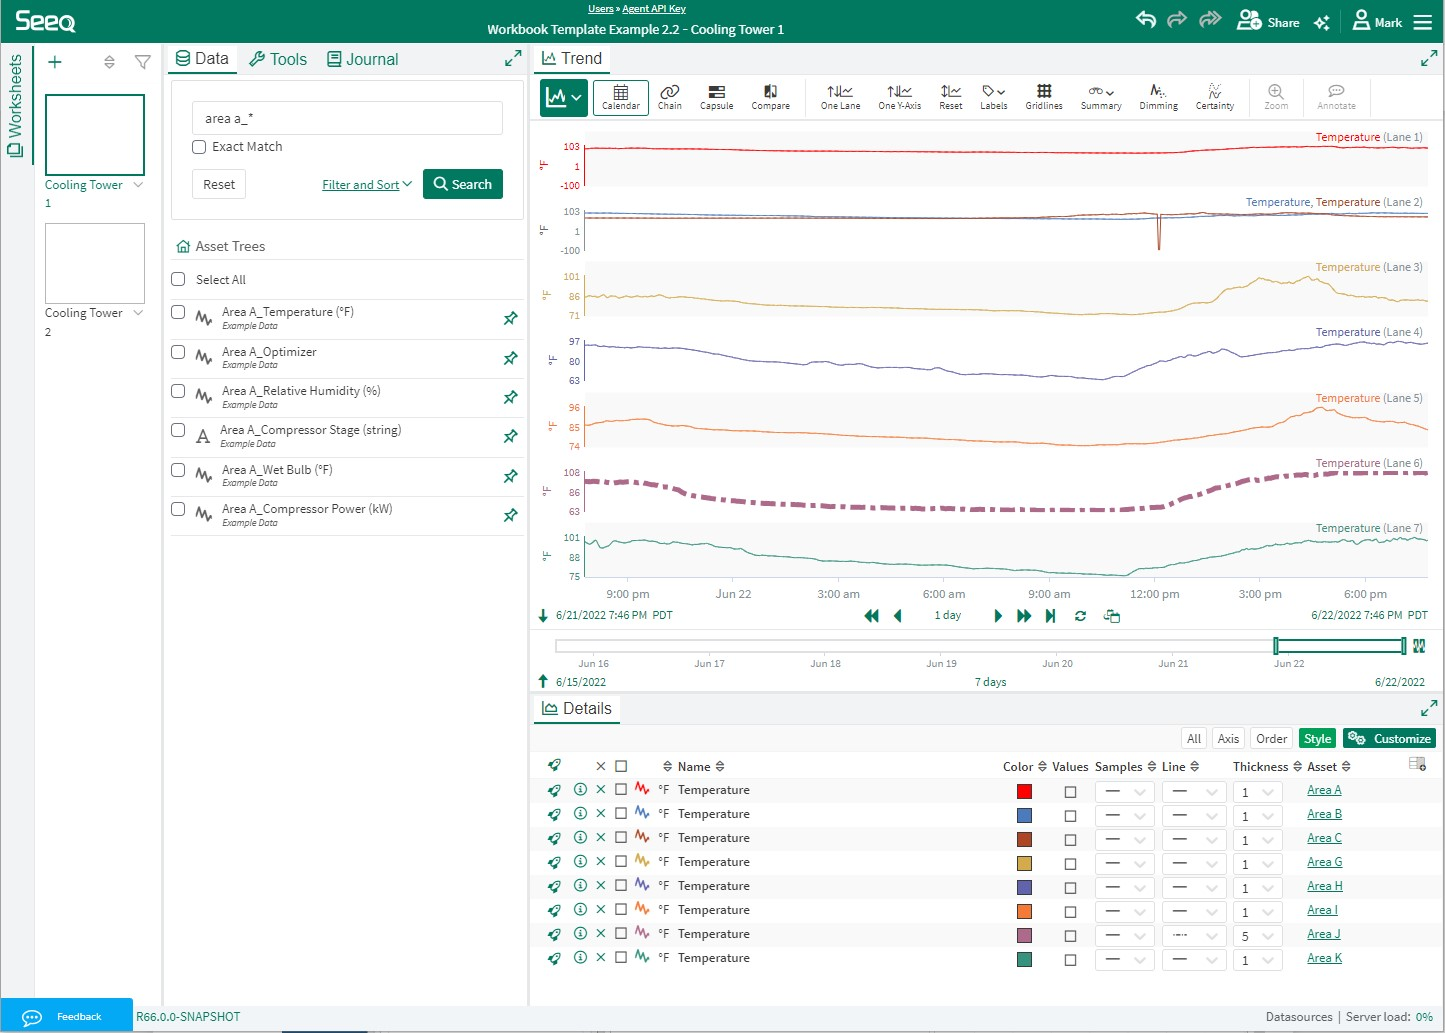

You can also combine the use of template parameters with manipulation of the display items. Specify the template parameters and then add/remove/modify rows in the Worksheet's `display_items` DataFrame. Added rows will need to have valid `ID`, `Name` and `Type` fields, which naturally come from `spy.search()` calls as you see in the example above.

## Pushing a Template Organizer Topic

A template Organizer Topic can also be pushed, with specific content that you specify using a method that builds upon what you learned above.

Since Organizer Topics are nearly always paired with a Workbench Analysis workbook that contains its content, you will be loading and pushing both in this example.

We are going to re-use the template objects from the previous example, but this time we will push all of them instead of just the Workbench Analysis.

### A Single Topic Document with Multiple Assets

In this first example, we will create a single Topic Document that has a separate _section_ for each asset.

In [16]:
workbooks = spy.workbooks.load('./Support Files/Workbook Templates.zip',
                               as_template_with_label=f'{spy.user.username} Workbook Template Example 3')

topic = workbooks['Topic Template']
analysis = workbooks['Analysis Template']

This Topic template looks like so in the Organizer user interface:

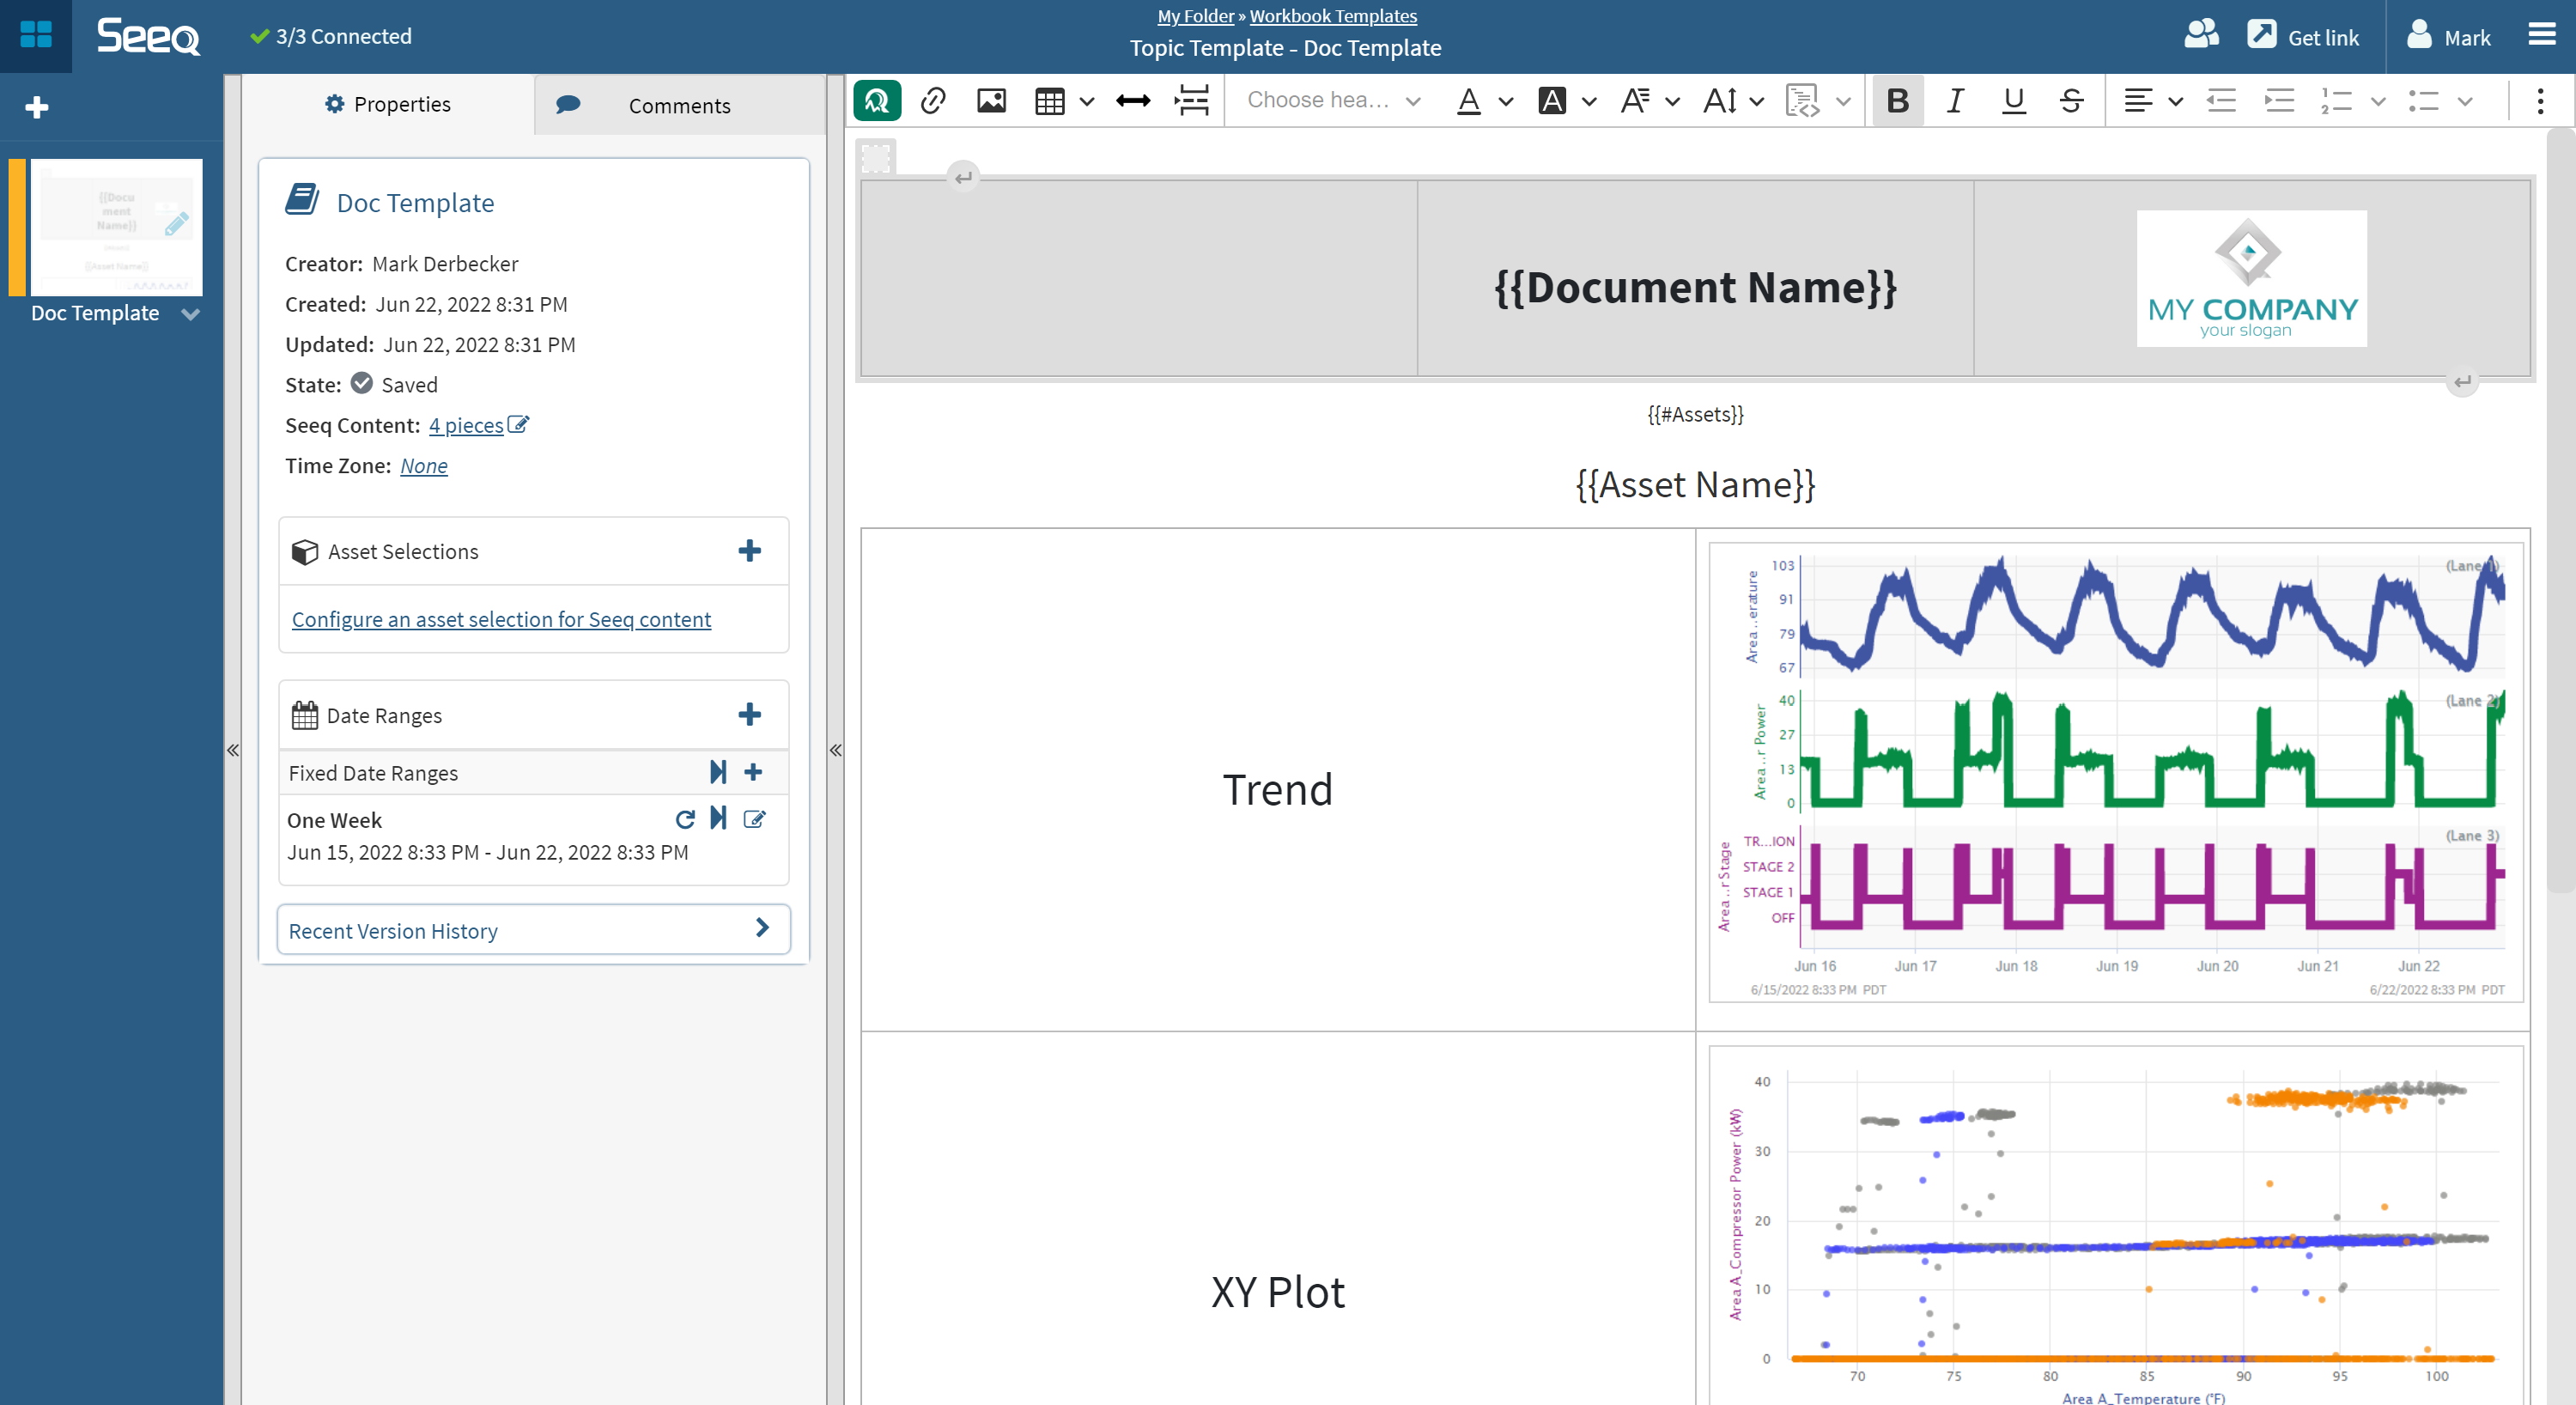

Notice that there is some embedded content and there are some mustache variables. In particular, you can see an `{{#Assets}}` mustache designation, and if you were to scroll to the bottom, you would also see an `{{/Assets}}` entry too. This is a mustache _section_, which allows us to repeat a block of the document several times.

(Note that if you want to exert more precise control over how your section is rendered -- for example, if you want each section to be rendered by a `<tr>` row in a table instead of as separate tables -- you can use the `pretty_print_html=True` argument when you save the workbook templates, and then you can manually go into the saved HTML files and tweak where the Mustache tokens are placed.)

As you'll see below, we are going to have a block for each asset.

In [17]:
document = topic.documents['Doc Template']

print(document.code)

document.parameters = {
    "Document Name": None,
    "Assets": [
        {
            "Asset Name": None,
            "25AF462C-602A-4E13-B50D-5DEB92CB37B5 [Embedded Content] Users >> mark-derbecker@seeq-com >> Workbook Templates >> Analysis Template >> Trend Template": None,
            "76B4412D-3B08-48B7-ABF9-ED8432DAA5CE [Embedded Content] Users >> mark-derbecker@seeq-com >> Workbook Templates >> Analysis Template >> XY Plot Template": None,
            "44392AAB-D443-4D2D-ACF0-055869875558 [Embedded Content] Users >> mark-derbecker@seeq-com >> Workbook Templates >> Analysis Template >> Treemap Template": None,
            "D4F167B3-E8BA-4FAA-86B3-05877E2D4250 [Embedded Content] Users >> mark-derbecker@seeq-com >> Workbook Templates >> Analysis Template >> Table Template": None
        }
    ]
}


Notice that the parameters code for the document contains an `Assets` entry, and it's a list that includes entries for each of the pieces of embedded content (as well as for the mustache variable `Asset Name`). We will specify a list of entries that are specific to each asset. First we need to create a set of content entries in the form of worksheet templates. Let's look at the code for each worksheet:

In [18]:
trend_template = analysis.worksheets['Trend Template']
xy_plot_template = analysis.worksheets['XY Plot Template']
treemap_template = analysis.worksheets['Treemap Template']
table_template = analysis.worksheets['Table Template']

print(trend_template.code)
print(xy_plot_template.code)
print(treemap_template.code)
print(table_template.code)

worksheet.parameters = {
    "9564A6B8-8A8F-4F6D-AC63-00EA38962B7A [Signal] Area A_Temperature": None,
    "D2C089B6-CE85-46FC-8392-E11CC0C08336 [Signal] Area A_Compressor Stage": None,
    "DCED9C36-A4BE-4783-9216-DC06B3F57D8C [Signal] Area A_Compressor Power": None,
    "Temperature Journal Link Text": None,
    "Compressor Power Journal Link Text": None,
    "Compressor Stage Journal Link Text": None,
    "favorite color": None
}
worksheet.parameters = {
    "9564A6B8-8A8F-4F6D-AC63-00EA38962B7A [Signal] Area A_Temperature": None,
    "DCED9C36-A4BE-4783-9216-DC06B3F57D8C [Signal] Area A_Compressor Power": None
}
worksheet.parameters = {
    "07F3161F-6644-4505-BC33-16D6155B004E [Condition] Hot": None,
    "D16FC368-AE8E-47B4-B1A3-9C2A3FBA2BB6 [Asset] Example >> Cooling Tower 1": None,
    "4B40EAFC-91ED-4AB0-8199-F21AF40A8350 [Asset] Example >> Cooling Tower 1 >> Area A": None,
    "8A4F0E26-8A0C-4127-9E11-B67E031C6049 [Signal] Example >> Cooling Tower 1 >> Area A >> Temperature": 

We're going to create a separate set of worksheets _per asset_. We'll do that by making a copy of each worksheet template in a `for` loop, and we'll store them in a dictionary for later use.

In [19]:
# We're going to reuse this code a couple of times, so we'll put it in a function
def create_worksheets(analysis):
    trend_template = analysis.worksheets['Trend Template']
    xy_plot_template = analysis.worksheets['XY Plot Template']
    treemap_template = analysis.worksheets['Treemap Template']
    table_template = analysis.worksheets['Table Template']

    worksheet_templates = dict()
    for asset in ['Waveforms 1', 'Waveforms 2']:
        # We create a copy of the worksheets for each asset, and it must have a unique label. So we incorporate
        # the asset name into the label.
        unique_label = f'{spy.user.username} Workbook Template Example 3 - {asset}'

        trend_worksheet = trend_template.copy(unique_label)
        trend_worksheet.name = f'{asset} Trend'
        trend_worksheet.parameters = {
            "DCED9C36-A4BE-4783-9216-DC06B3F57D8C [Signal] Area A_Compressor Power": {'Asset': asset, 'Name': 'Sinusoid'},
            "9564A6B8-8A8F-4F6D-AC63-00EA38962B7A [Signal] Area A_Temperature": {'Asset': asset, 'Name': 'Sawtooth'},
            "D2C089B6-CE85-46FC-8392-E11CC0C08336 [Signal] Area A_Compressor Stage": {'Asset': asset, 'Name': 'Square'},
            "Temperature Journal Link Text": 'Sawtooth',
            "Compressor Power Journal Link Text": 'Sinusoid',
            "Compressor Stage Journal Link Text": 'Square',
            "favorite color": 'eggshell' if asset.endswith('1') else 'violet'
        }

        xy_plot_worksheet = xy_plot_template.copy(unique_label)
        xy_plot_worksheet.name = f'{asset} XY Plot'
        xy_plot_worksheet.parameters = {
            "DCED9C36-A4BE-4783-9216-DC06B3F57D8C [Signal] Area A_Compressor Power": {'Asset': asset, 'Name': 'Sinusoid'},
            "9564A6B8-8A8F-4F6D-AC63-00EA38962B7A [Signal] Area A_Temperature": {'Asset': asset, 'Name': 'Sawtooth'}
        }

        treemap_worksheet = treemap_template.copy(unique_label)
        treemap_worksheet.name = f'{asset} Treemap'
        treemap_worksheet.parameters = {
            "8A4F0E26-8A0C-4127-9E11-B67E031C6049 [Signal] Example >> Cooling Tower 1 >> Area A >> Temperature": {
                'Asset': asset, 'Name': 'Sawtooth'},
            "07F3161F-6644-4505-BC33-16D6155B004E [Condition] Hot": {'Asset': asset, 'Name': 'Hours'},
            "D16FC368-AE8E-47B4-B1A3-9C2A3FBA2BB6 [Asset] Cooling Tower 1": {'Asset': 'Waveforms', 'Type': 'Asset'},
            "4B40EAFC-91ED-4AB0-8199-F21AF40A8350 [Asset] Example >> Area A": {'Asset': asset, 'Type': 'Asset'}
        }

        table_worksheet = table_template.copy(unique_label)
        table_worksheet.name = f'{asset} Table'
        table_worksheet.parameters = {
            "DCED9C36-A4BE-4783-9216-DC06B3F57D8C [Signal] Area A_Compressor Power": {'Asset': asset, 'Name': 'Sinusoid'},
            "D2C089B6-CE85-46FC-8392-E11CC0C08336 [Signal] Area A_Compressor Stage": {'Asset': asset, 'Name': 'Square'},
            "9564A6B8-8A8F-4F6D-AC63-00EA38962B7A [Signal] Area A_Temperature": {'Asset': asset, 'Name': 'Sawtooth'}
        }

        worksheet_templates[asset] = {
            'Trend': trend_worksheet,
            'XY Plot': xy_plot_worksheet,
            'Treemap': treemap_worksheet,
            'Table': table_worksheet,
        }
        
    return worksheet_templates


Now we will fill in the Organizer Topic document's template parameters by using the worksheet templates that we assembled above. Note below that we are using a [list comprehension](https://www.w3schools.com/python/python_lists_comprehension.asp) to create the `Assets` list of each Waveform asset.

In [20]:
worksheet_templates = create_worksheets(analysis)

document.name = "Workbook Template Example 3"

document.parameters = {
    "Document Name": "Waveform Monitoring and Diagnostics",
    "Assets": [
        {
            "Asset Name": asset,
            "25AF462C-602A-4E13-B50D-5DEB92CB37B5 [Embedded Content] Users >> mark.derbecker@seeq.com >> Workbook Templates >> Analysis Template >> Trend Template":
                worksheet_templates[asset]['Trend'],
            "76B4412D-3B08-48B7-ABF9-ED8432DAA5CE [Embedded Content] Users >> mark.derbecker@seeq.com >> Workbook Templates >> Analysis Template >> XY Plot Template":
                worksheet_templates[asset]['XY Plot'],
            "44392AAB-D443-4D2D-ACF0-055869875558 [Embedded Content] Users >> mark.derbecker@seeq.com >> Workbook Templates >> Analysis Template >> Treemap Template":
                worksheet_templates[asset]['Treemap'],
            "D4F167B3-E8BA-4FAA-86B3-05877E2D4250 [Embedded Content] Users >> mark.derbecker@seeq.com >> Workbook Templates >> Analysis Template >> Table Template":
                worksheet_templates[asset]['Table']
        }
        for asset in ['Waveforms 1', 'Waveforms 2']
    ]
}

Now we do some final bookkeeping to tidy things up and push. Click on the link that corresponds to the Topic to see it in Organizer.

In [21]:
# Give the topic and analysis a specific name
topic.name = 'Workbook Template Example 3'
analysis.name = 'Workbook Template Example 3'

# Since each of the worksheets we created above is a copy of the template, the template
# worksheets will show separately from the "Waveforms" worksheets. We want to "hide" the
# template worksheets because it's often not interesting and perhaps confusing
# for the user to see the templates. So we set the "Archived" property to True -- they
# will still be pushed, but they'll be in the trash and the user won't see them.
analysis.worksheets['Trend Template']['Archived'] = True
analysis.worksheets['XY Plot Template']['Archived'] = True
analysis.worksheets['Treemap Template']['Archived'] = True
analysis.worksheets['Table Template']['Archived'] = True

# Note that we pass in a list that includes the Analysis and the Topic
pushed_df = spy.push(metadata=metadata_df, workbook=[topic, analysis])

# Show the inner Push Workbooks status object's display instead of the metadata push status,
# since it has links to the Topic.
pushed_df.spy.status.inner['Push Workbooks'].display()

,ID,Name,Type,Workbook Type,Count,Time,Errors,Result,Pushed Workbook ID,URL
0,F01FD57A-1112-4020-9430-CF27C2847D1B agent_api_key Workbook Template Example 3,Workbook Template Example 3,Workbook,Analysis,39,00:00:01.97,0,Success,0EF5A988-0214-EE90-9DD4-36652A590462,link
1,90931EF8-D80B-4F22-8568-3683DD806D50 agent_api_key Workbook Template Example 3,Workbook Template Example 3,Workbook,Topic,2,00:00:00.30,0,Success,0EF5A988-026A-75C0-B303-ECD1EC50AFE9,link


The Organizer Topic should have two sections, one for each Waveform asset, the second of which should look something like this:

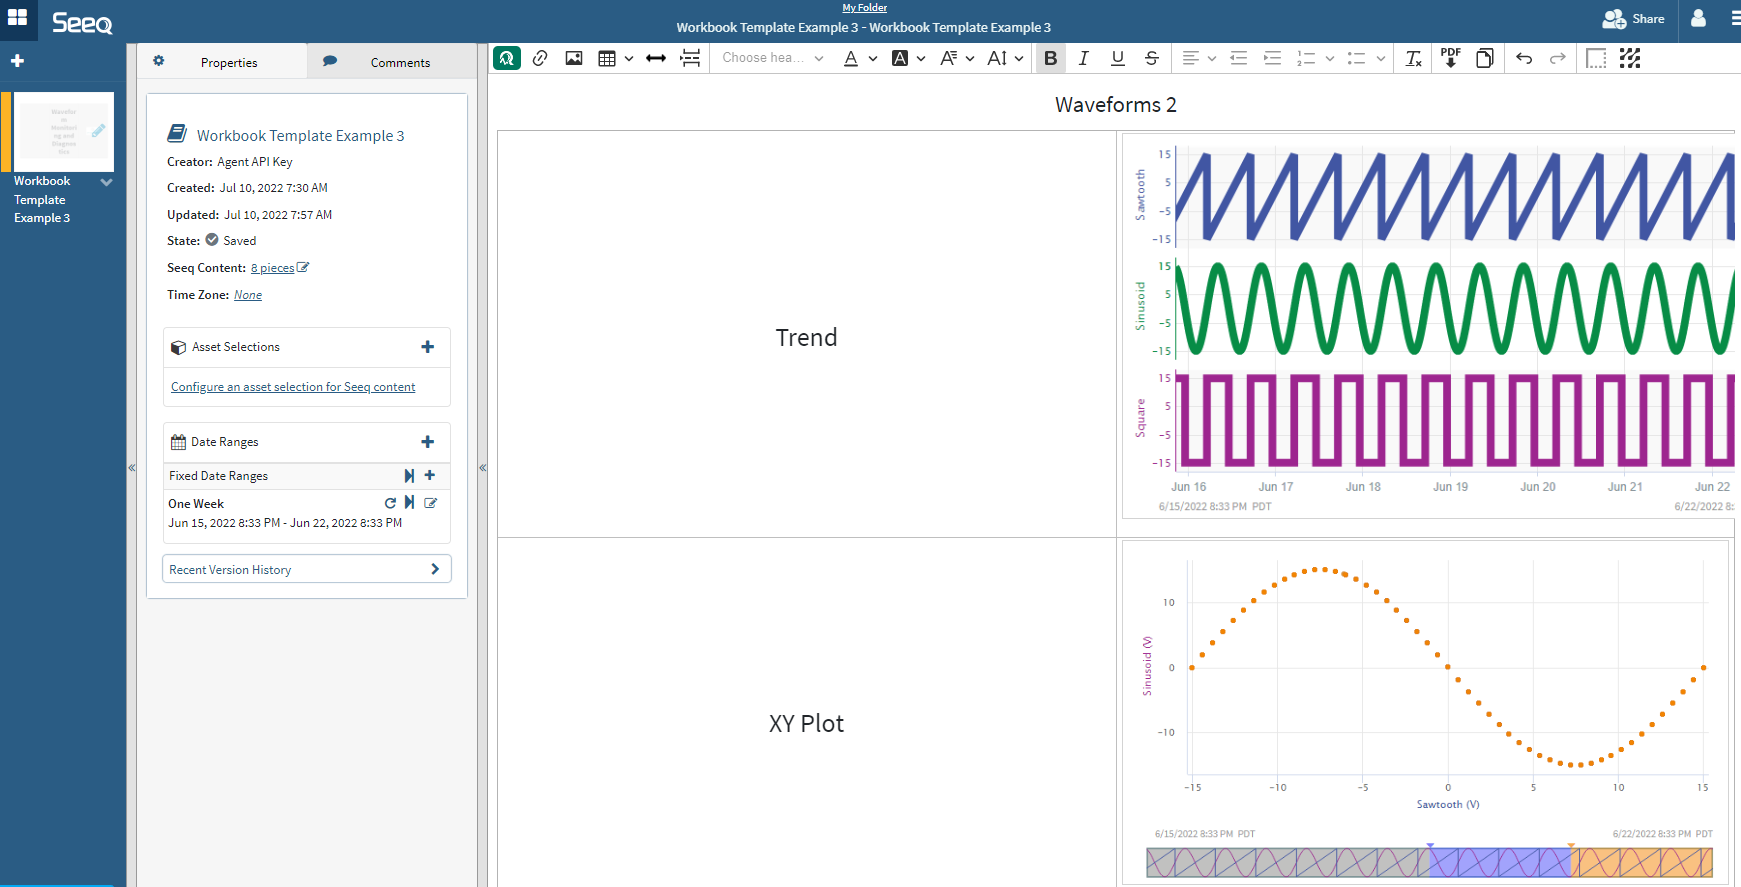

### A Topic with a Document for each Asset

Now let's see how it would look if you wanted a separate Topic Document for each Asset instead of putting them all in one Document.

It looks very similar, but you'll see that we use the `copy()` function to make separate documents.

In [22]:
workbooks = spy.workbooks.load('./Support Files/Workbook Templates.zip',
                               as_template_with_label=f'{spy.user.username} Workbook Template Example 4')

topic = workbooks['Topic Template']
analysis = workbooks['Analysis Template']

worksheet_templates = create_worksheets(analysis)

topic.name = 'Workbook Template Example 4'
analysis.name = 'Workbook Template Example 4'

# Grab the one and only document as a template. Note that it's name is left over from the previous example.
doc_template = topic.documents['Doc Template']

for asset in ['Waveforms 1', 'Waveforms 2']:
    document = doc_template.copy(label=f'Document for {asset}')
    document.name = asset

    document.parameters = {
        "Document Name": "Waveform Monitoring and Diagnostics - v2",
        
        # This time, the Assets list is only one item long, since we're putting the Assets in different documents.
        "Assets": [
            {
                "Asset Name": asset,
                "25AF462C-602A-4E13-B50D-5DEB92CB37B5 [Embedded Content] Users >> mark.derbecker@seeq.com >> Workbook Templates >> Analysis Template >> Trend Template":
                    worksheet_templates[asset]['Trend'],
                "76B4412D-3B08-48B7-ABF9-ED8432DAA5CE [Embedded Content] Users >> mark.derbecker@seeq.com >> Workbook Templates >> Analysis Template >> XY Plot Template":
                    worksheet_templates[asset]['XY Plot'],
                "44392AAB-D443-4D2D-ACF0-055869875558 [Embedded Content] Users >> mark.derbecker@seeq.com >> Workbook Templates >> Analysis Template >> Treemap Template":
                    worksheet_templates[asset]['Treemap'],
                "D4F167B3-E8BA-4FAA-86B3-05877E2D4250 [Embedded Content] Users >> mark.derbecker@seeq.com >> Workbook Templates >> Analysis Template >> Table Template":
                    worksheet_templates[asset]['Table']
            }
        ]
    }

# Since we have created a separate document for each asset, we don't want to see the template doc in the Topic
doc_template['Archived'] = True

pushed_df = spy.push(metadata=metadata_df, workbook=[topic, analysis])
pushed_df.spy.status.inner['Push Workbooks'].display()

,ID,Name,Type,Workbook Type,Count,Time,Errors,Result,Pushed Workbook ID,URL
0,F01FD57A-1112-4020-9430-CF27C2847D1B agent_api_key Workbook Template Example 4,Workbook Template Example 4,Workbook,Analysis,39,00:00:02.64,0,Success,0EF5C014-9C38-FDD0-8C6E-671A8F9D8C54,link
1,90931EF8-D80B-4F22-8568-3683DD806D50 agent_api_key Workbook Template Example 4,Workbook Template Example 4,Workbook,Topic,6,00:00:00.72,0,Success,0EF5C014-9CC1-F950-93CC-78A73CCE27AA,link


#### Alternative Method: Using Asset Selections

You may have a Topic Document that contains an Asset Selection, and you simply want to create separate documents and "pre-select" that asset, and often because you want to have each separate document update on a schedule so that all of the content loads quickly when you try to view it.

You can accomplish this by using the Topic Document's parameters to set an Asset for the Asset Selection.

To illustrate, first we push some workbooks that would be representative of your starting point: A Workbench Analysis and an Organizer Topic that references it.

In [23]:
# Load and push the basis for this example.
workbooks = spy.workbooks.load('./Support Files/Workbook Templates.zip')

pushed_workbooks_df = spy.workbooks.push([
    workbooks['Asset Selector Analysis Template'],
    workbooks['Asset Selector Topic Template']
], label=f'{spy.user.username} Workbook Template Example 4 - Example Basis')

# Construct a DataFrame of the pushed workbooks for use below
workbooks_to_pull_df = pushed_workbooks_df[pushed_workbooks_df['Workbook Type'] == 'Topic'].copy()
workbooks_to_pull_df.drop(columns=['ID'], inplace=True)
workbooks_to_pull_df.rename(columns={'Pushed Workbook ID': 'ID'}, inplace=True)

,ID,Name,Type,Workbook Type,Count,Time,Errors,Result,Pushed Workbook ID,URL
0,0EF59E6B-546A-6230-8251-02C2AE9EE8C1,Asset Selector Analysis Template,Workbook,Analysis,13,00:00:00.62,0,Success,0EF5A97D-AA93-EAE0-A973-567A663D716A,link
1,0EF59E6D-EE87-60A0-A4E3-AA13C6B2FE18,Asset Selector Topic Template,Workbook,Topic,2,00:00:00.29,0,Success,0EF5A97D-B036-E8D0-A7C6-B15F8201D867,link


Now that we have the basis for our example, we'll pull these workbooks as a template.

In [24]:
# Pull the workbooks with a template label
templates = spy.workbooks.pull(workbooks_to_pull_df, as_template_with_label=f'{spy.user.username} Workbook Template Example 4')

topic_template = templates['Asset Selector Topic Template']
doc_template = topic_template.documents[0]

,ID,Name,Workbook Type,Count,Time,Errors,Result,Path
0,0EF5A97D-B036-E8D0-A7C6-B15F8201D867,Asset Selector Topic Template,Topic,4,00:00:00.20,0,Success,nan
1,0EF5A97D-AA93-EAE0-A973-567A663D716A,Asset Selector Analysis Template,Analysis,13,00:00:00.34,0,Success,My Folder


The following code finds all the assets under Cooling Tower 1 and then, in a loop, adds separate document for each.

It also takes the opportunity to "spread out" the background schedule by ten minutes so that they aren't all being done simultaneously.

In [25]:
# Find all the assets we want
areas = spy.search({'Path': 'Example >> Cooling Tower 1', 'Type': 'Asset'}, old_asset_format=False, recursive=False)

hour = 2
minute = 17
for _, area in areas.iterrows():
    area_doc = doc_template.copy(area['ID'])
    area_doc.parameters = {
        "[Asset Selection] Example >> Cooling Tower 1 >> Area A": area,

        # The name of each doc in the template is "Asset: {{Asset Name}}", which causes "Asset Name" to be available
        # for substitution in the template parameters.
        "Asset Name": area['Name']
    }

    # Spread out the background schedule. We use a convenience method that turns an English-language string
    # into a Cron string. If you want more precise control, the format of the Cron string is documented here:
    # http://www.quartz-scheduler.org/documentation/quartz-2.3.0/tutorials/crontrigger.html
    cron_string = spy.utils.parse_schedule_string(f'Every day at {hour}:{minute}')
    area_doc.schedule['Cron Schedule'] = [cron_string]
    
    minute += 10
    if minute >= 60:
        minute -= 60
        hour += 1

# Remove the template doc so it doesn't get pushed
topic_template.documents.remove(doc_template)

topic_template.name = 'Scale Across Assets with Asset Selections'

# We're only pushing the Topic template (and excluding the Analysis template). We do this because the Analysis
# (that we want to use) already exists on the server, and we have no interest in creating a second (duplicate)
# Analysis. So the assume_dependencies_exist=True argument is important because otherwise you would get errors
# about dependencies not being found, and these errors would prevent the push from completing.
spy.workbooks.push(topic_template, assume_dependencies_exist=True)

,ID,Name,Type,Workbook Type,Count,Time,Errors,Result,Pushed Workbook ID,URL
0,0EF5A97D-B036-E8D0-A7C6-B15F8201D867 agent_api_key Workbook Template Example 4,Scale Across Assets with Asset Selections,Workbook,Topic,8,00:00:01.99,0,Success,0EF5A97E-7C58-FDA0-BD3E-7A843D25C152,link


,ID,Name,Type,Workbook Type,Count,Time,Errors,Result,Pushed Workbook ID,URL
0,0EF5A97D-B036-E8D0-A7C6-B15F8201D867 agent_api...,Scale Across Assets with Asset Selections,Workbook,Topic,8,0:00:01.986297,0,Success,0EF5A97E-7C58-FDA0-BD3E-7A843D25C152,http://localhost:34216/workbook/0EF5A97E-7C58-...


Click the "link" in the far right of the green box and take a look at the pushed Topic, you should see a separate document for each asset, and the schedule is slightly different for each.

### A Topic Document with an Image

In the examples above, you saw how to use syntax like `{{Asset Name}}` as a placeholder in the template that became a parameter you could specify in your SPy code.

You can do a similar thing with pictures/images in your document. The most common use for this capability is to push a custom visualization (that you created in Python) into your document, and typically you'll want to do that on a schedule. A separate [Data Lab Visualizations](Data%20Lab%20Visualizations.ipynb) notebook walks you through how to accomplish that.